# 模型预测分类

## 训练集、测试集划分

In [1]:
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

In [2]:
data = pd.read_csv('feature1.csv')
label = pd.read_csv('result1.csv')
# data = pd.read_csv('feature0.csv')
# label = pd.read_csv('result0.csv')
# label = pd.read_csv('result_label.csv')

In [3]:
data = data.drop(data.columns[0],axis=1)

In [4]:
label = label.drop(label.columns[0],axis=1)

In [46]:
x_train,x_test,y_train,y_test = train_test_split(data,label,test_size=0.3)

In [7]:
x_train.shape

(107501, 14)

In [8]:
y_train.head()

,result
98742,0
113784,0
66765,0
12238,0
91757,0


In [9]:
x_train.head()

,coupon,distance_day,login_diff_time,course_order_num,coupon_visit,model_num,login_day,login_time,learn_num,main_home2,age_month,video_read,main_home,chinese_subscribe_num
98742,0,29,1.67,0,0,11.2154,3,39,5,12,76,40,38,1
113784,0,65,0.80,0,0,3.1579,5,33,4,103,172,31,112,0
66765,0,366,1.00,0,0,6.0933,7,15,5,146,78,39,144,0
12238,0,34,0.86,0,0,13.5328,7,18,5,63,53,33,90,1
91757,0,371,3.00,0,0,12.2061,2,89,1,24,55,57,36,0


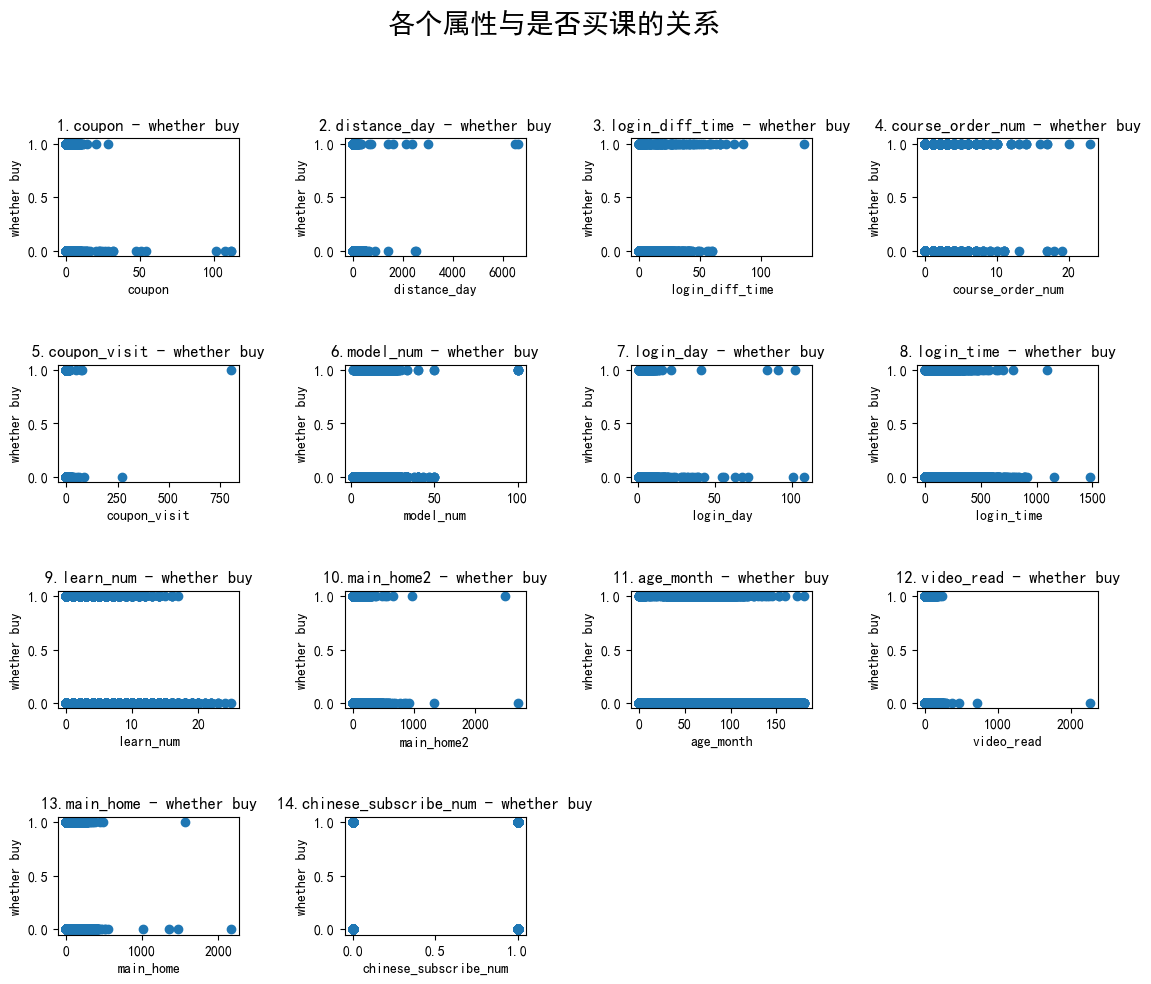

In [295]:
plt.rcParams['font.sans-serif']='SimHei'
plt.rcParams['axes.unicode_minus']=False

titles=x_train.columns.tolist()

plt.figure(figsize=(12,12))                      #绘图尺寸

for i in range(14):                              #i=0,1,2,...12
    plt.subplot(5, 4,(i+1))
    plt.scatter(x_train[x_train.columns[i]], y_train)           #散点图描点
    
    plt.title(str(i+1)+"."+titles[i]+" - whether buy",loc='center') #标题
    
    plt.xlabel(titles[i],loc='center')                        #坐标轴标题
    plt.ylabel("whether buy")

plt.tight_layout(pad=3.5,rect=[0,0, 1,0.95])                 #自动调整子图位置
plt.suptitle("各个属性与是否买课的关系", x=0.5,y=1,fontsize=20)

plt.show()  


## 选取分类器

In [303]:
from sklearn.linear_model import PassiveAggressiveClassifier
pac = PassiveAggressiveClassifier(random_state=42)
pac.fit(x_train,y_train)
score_pac = pac.score(x_test,y_test)

D:\anaconda3\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [304]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(random_state=42)
rfc.fit(x_train,y_train)
score_rfc = rfc.score(x_test,y_test)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_19756\2448767921.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(x_train,y_train)


In [306]:
from sklearn.linear_model import SGDClassifier
sgd=SGDClassifier(random_state=42)
sgd.fit(x_train,y_train)
score_sgd = sgd.score(x_test,y_test)

In [308]:
from sklearn.neighbors import KNeighborsClassifier
knc = KNeighborsClassifier()
knc.fit(x_train,y_train)
score_knc=knc.score(x_test,y_test)

D:\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:200: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


In [309]:
xgb=XGBClassifier()
xgb.fit(x_train,y_train)
score_xgb=xgb.score(x_test,y_test)

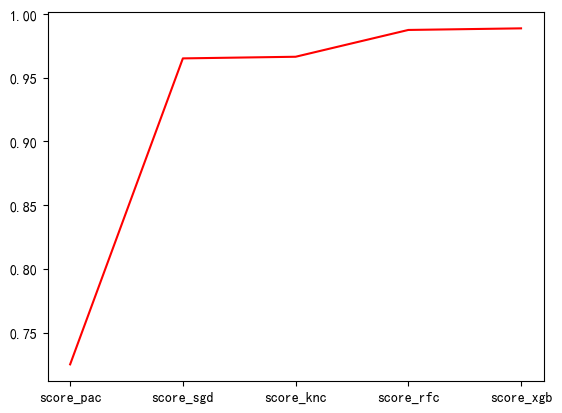

In [312]:
x = np.arange(1,6)
plt.subplot(111)
plt.plot(x, [score_pac,score_sgd,score_knc,score_rfc,score_xgb], 'r-')
plt.xticks(x, labels=['score_pac',  'score_sgd', 'score_knc',,'score_rfc','score_xgb'])

plt.show()

## 调参

In [288]:
x_train.head()

,coupon,distance_day,login_diff_time,course_order_num,coupon_visit,model_num,login_day,login_time,learn_num,main_home2,age_month,video_read,main_home,chinese_subscribe_num
119312,0,0,0.67,0,0,8.8235,3,66,2,96,57,35,69,0
67708,0,154,0.50,0,0,15.4150,2,7,1,17,55,14,38,0
11211,0,377,2.33,0,0,4.7619,3,9,1,32,90,20,30,0
58917,1,77,1.33,1,0,5.6734,3,329,1,36,72,51,40,0
27481,0,9,1.75,0,0,6.5903,4,18,1,24,66,0,22,0


In [289]:
x_train.shape

(83612, 14)

### n_estimators

In [164]:
# 调参，绘制学习曲线来调参n_estimators（对决策树影响最大）
score_lt = []

# 每隔10步建立一个随机森林，获得不同n_estimators的得分
for i in range(0,200,10):
    rfc = XGBClassifier(n_estimators=i+1
                        ,random_state=90)
    score = cross_val_score(rfc,x_train ,y_train, cv=5,scoring='recall').mean()
    score_lt.append(score)
score_max = max(score_lt)
print('最大得分：{}'.format(score_max),
      '子树数量为：{}'.format(score_lt.index(score_max)*10+1))

最大得分：0.7610810810810811 子树数量为：81


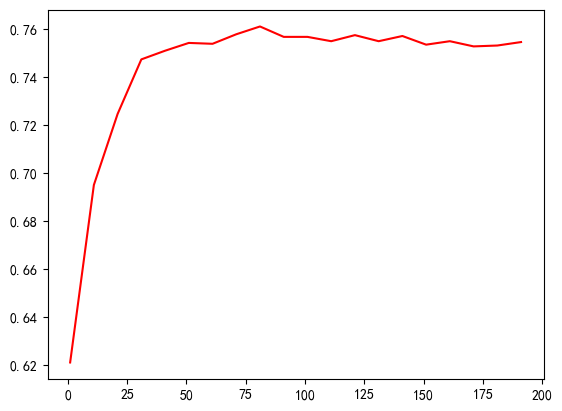

In [165]:
# 绘制学习曲线
x = np.arange(1,201,10)
plt.subplot(111)
plt.plot(x, score_lt, 'r-')
plt.show()

最大得分：0.7676051216788302 子树数量为：83


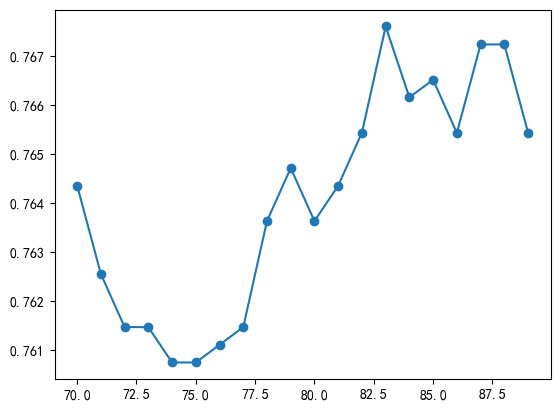

In [166]:
# 在81附近缩小n_estimators的范围为70-90
score_lt = []
for i in range(70,90):
    rfc = XGBClassifier(n_estimators=i
                                ,random_state=90)
    score = cross_val_score(rfc,x_train ,y_train, cv=10,scoring='recall').mean()
    score_lt.append(score)
score_max = max(score_lt)
print('最大得分：{}'.format(score_max),
      '子树数量为：{}'.format(score_lt.index(score_max)+70))

# 绘制学习曲线
x = np.arange(70,90)
plt.subplot(111)
plt.plot(x, score_lt,'o-')
plt.show()

In [167]:
model = XGBClassifier(n_estimators=83
                        ,random_state=90)

### max_depth

In [168]:
# 用网格搜索调整max_depth
param_grid = {'max_depth':np.arange(1,10)}
GS = GridSearchCV(model, param_grid, cv=10,scoring='recall')
GS.fit(x_train,y_train)

best_param = GS.best_params_
best_score = GS.best_score_
print(best_param, best_score)

{'max_depth': 6} 0.7676051216788302


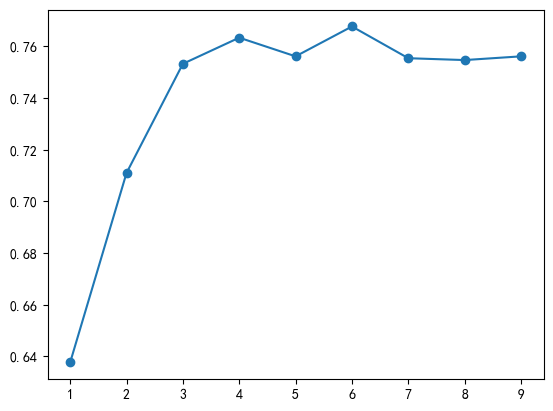

In [169]:
score=GS.cv_results_['mean_test_score']
x = np.arange(1,10)
plt.subplot(111)
plt.plot(x,score,'o-')
plt.show()

In [170]:
model = XGBClassifier(n_estimators=83,
                      max_depth=6,
                    random_state=90)

### min_child_weight

In [171]:
# 用网格搜索调整min_child_weight
param_grid = {'min_child_weight':np.arange(1,10)}
GS = GridSearchCV(model, param_grid, cv=10,scoring='recall')
GS.fit(x_train,y_train)

best_param = GS.best_params_
best_score = GS.best_score_
print(best_param, best_score)

{'min_child_weight': 1} 0.7676051216788302


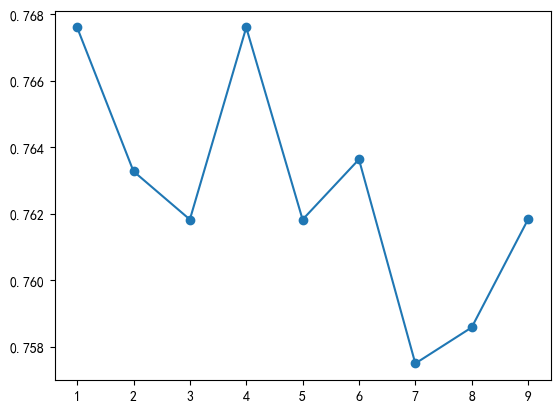

In [172]:
score=GS.cv_results_['mean_test_score']
x = np.arange(1,10)
plt.subplot(111)
plt.plot(x,score,'o-')
plt.show()

In [173]:
model = XGBClassifier(n_estimators=83,
                      max_depth=6,
                      min_child_weight=1,
                      random_state=90)

### gamma

In [174]:
# 用网格搜索调整 gamma
param_grid = {'gamma':[i/10.0 for i in range(0,11)] }
GS = GridSearchCV(model, param_grid, cv=10,scoring='recall')
GS.fit(x_train,y_train)

best_param = GS.best_params_
best_score = GS.best_score_
print(best_param, best_score)

{'gamma': 0.0} 0.7676051216788302


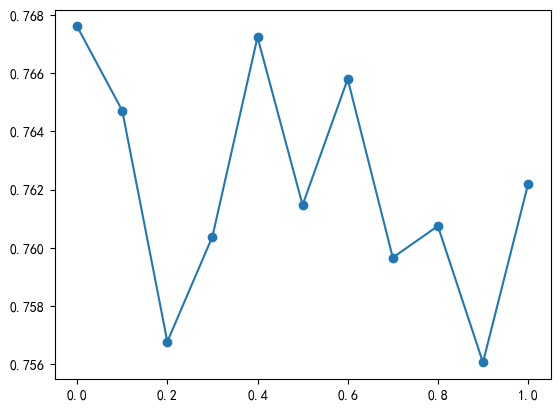

In [175]:
score=GS.cv_results_['mean_test_score']
x = [i/10.0 for i in range(0,11)]
plt.subplot(111)
plt.plot(x,score,'o-')
plt.show()

In [176]:
model = XGBClassifier(n_estimators=83,
                      max_depth=6,
                      min_child_weight=1,
                      gamma=0,
                      random_state=90)

### colsample_bytree

In [195]:
param_grid = {'colsample_bytree': [0.8,0.9,1.0]}
GS = GridSearchCV(model, param_grid, cv=10,scoring='recall')
GS.fit(x_train,y_train)

best_param = GS.best_params_
best_score = GS.best_score_
print(best_param, best_score)

{'colsample_bytree': 1.0} 0.7127522530711892


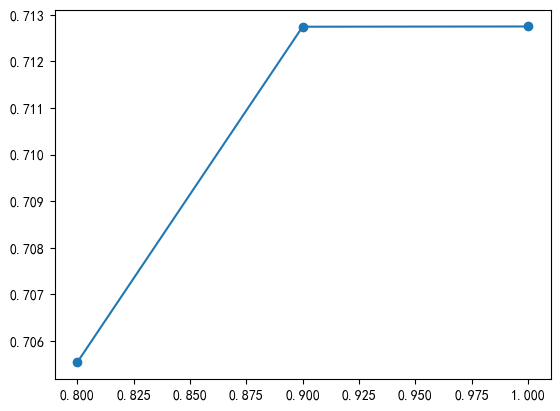

In [197]:
score=GS.cv_results_['mean_test_score']
x = [0.8,0.9,1.0]
plt.subplot(111)
plt.plot(x,score,'o-')
plt.show()

In [198]:
model = XGBClassifier(n_estimators=83,
                      max_depth=6,
                      min_child_weight=1,
                      gamma=0,
                      learning_rate=0.25,
                      objective ='binary:logitraw',
                      colsample_bytree=1,
                      random_state=90)

### subsample 

In [199]:
param_grid = {'subsample':[i/10.0 for i in range(5,10)]}
GS = GridSearchCV(model, param_grid, cv=10,scoring='recall')
GS.fit(x_train,y_train)

best_param = GS.best_params_
best_score = GS.best_score_
print(best_param, best_score)

{'subsample': 0.8} 0.723212476949848


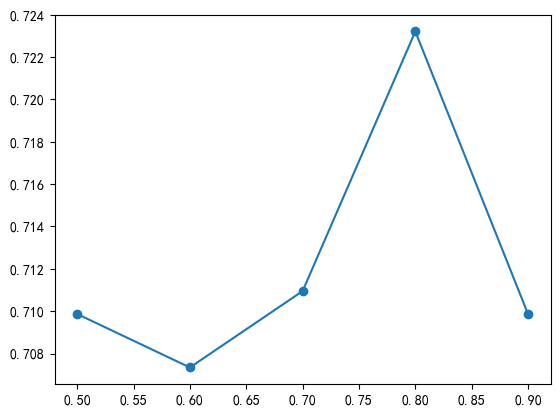

In [200]:
score=GS.cv_results_['mean_test_score']
x = [i/10.0 for i in range(5,10)]
plt.subplot(111)
plt.plot(x,score,'o-')
plt.show()

In [12]:
model = XGBClassifier(n_estimators=83,
                      max_depth=6,
                      min_child_weight=1,
                      gamma=0,
                      learning_rate=0.25,
                      objective ='binary:logitraw',
                      subsample=0.8,
                      colsample_bytree=1,
                      random_state=90)

## reg_alpha reg_lambda

In [216]:
param_grid = {'reg_alpha':[0, 0.005, 0.01, 0.05],
              'reg_lambda':[0, 0.3, 0.5,  1]
             }
GS = GridSearchCV(model, param_grid, cv=10,scoring='recall')
GS.fit(x_train,y_train)

best_param = GS.best_params_
best_score = GS.best_score_
print(best_param, best_score)

{'reg_alpha': 0, 'reg_lambda': 1} 0.723212476949848


In [218]:
model = XGBClassifier(n_estimators=83,
                      max_depth=6,
                      min_child_weight=1,
                      gamma=0,
                      learning_rate=0.25,
                      objective ='binary:logitraw',
                      subsample=0.8,
                      colsample_bytree=1,
                      reg_alpha=0,
                      reg_lambda=1,
                      random_state=90)

### learning rate

In [219]:
# 用网格搜索调整学习率
# 最后再调节学习率
param_grid = {'learning_rate': [0.01, 0.05, 0.07, 0.1, 0.12,0.15,0.2,0.25,0.3,0.35,0.4,0.45]}
GS = GridSearchCV(model, param_grid, cv=10,scoring='recall')
GS.fit(x_train,y_train)

best_param = GS.best_params_
best_score = GS.best_score_
print(best_param, best_score)

{'learning_rate': 0.25} 0.723212476949848


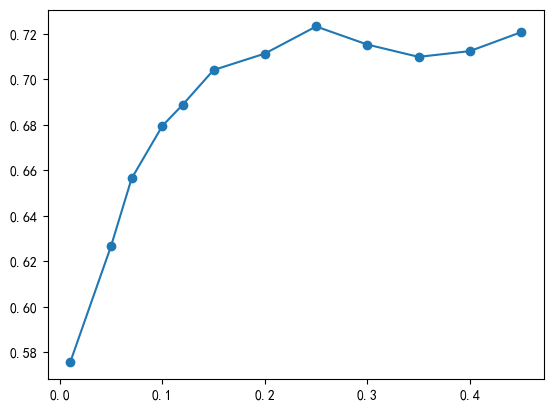

In [220]:
score=GS.cv_results_['mean_test_score']
x = [0.01, 0.05, 0.07, 0.1, 0.12,0.15,0.2,0.25,0.3,0.35,0.4,0.45]
plt.subplot(111)
plt.plot(x,score,'o-')
plt.show()


In [38]:
model = XGBClassifier(n_estimators=83,
                      max_depth=6,
                      min_child_weight=1,
                      gamma=0,
                      learning_rate=0.25,
                      objective ='binary:logitraw',
                      subsample=0.8,
                      colsample_bytree=1,
                      reg_alpha=0,
                      reg_lambda=1,
                      random_state=90)

In [39]:
train = [x_train, y_train]
eval = [x_test, y_test]
model.fit(x_train,y_train,eval_metric=['logloss','auc','error'],eval_set=[train,eval])
 

[0]	validation_0-logloss:0.07296	validation_0-auc:0.97618	validation_0-error:0.01619	validation_1-logloss:0.08593	validation_1-auc:0.97768	validation_1-error:0.01892
[1]	validation_0-logloss:-0.07921	validation_0-auc:0.97786	validation_0-error:0.01696	validation_1-logloss:0.00347	validation_1-auc:0.97917	validation_1-error:0.01909
[2]	validation_0-logloss:-0.30015	validation_0-auc:0.97909	validation_0-error:0.01517	validation_1-logloss:-0.21218	validation_1-auc:0.98024	validation_1-error:0.01658


D:\anaconda3\lib\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[3]	validation_0-logloss:-0.41599	validation_0-auc:0.97963	validation_0-error:0.01576	validation_1-logloss:-0.33553	validation_1-auc:0.98093	validation_1-error:0.01766
[4]	validation_0-logloss:-0.54884	validation_0-auc:0.98068	validation_0-error:0.01472	validation_1-logloss:-0.46154	validation_1-auc:0.98187	validation_1-error:0.01699
[5]	validation_0-logloss:-0.65706	validation_0-auc:0.98140	validation_0-error:0.01437	validation_1-logloss:-0.53899	validation_1-auc:0.98239	validation_1-error:0.01691
[6]	validation_0-logloss:-0.75546	validation_0-auc:0.98204	validation_0-error:0.01393	validation_1-logloss:-0.68006	validation_1-auc:0.98290	validation_1-error:0.01716
[7]	validation_0-logloss:-0.84235	validation_0-auc:0.98232	validation_0-error:0.01330	validation_1-logloss:-0.74642	validation_1-auc:0.98311	validation_1-error:0.01616
[8]	validation_0-logloss:-0.91624	validation_0-auc:0.98265	validation_0-error:0.01326	validation_1-logloss:-0.83310	validation_1-auc:0.98340	validation_1-error:

[52]	validation_0-logloss:-1.87971	validation_0-auc:0.99751	validation_0-error:0.00705	validation_1-logloss:-1.70314	validation_1-auc:0.99259	validation_1-error:0.01172
[53]	validation_0-logloss:-1.88793	validation_0-auc:0.99771	validation_0-error:0.00688	validation_1-logloss:-1.70639	validation_1-auc:0.99253	validation_1-error:0.01197
[54]	validation_0-logloss:-1.89219	validation_0-auc:0.99778	validation_0-error:0.00677	validation_1-logloss:-1.70506	validation_1-auc:0.99249	validation_1-error:0.01189
[55]	validation_0-logloss:-1.89405	validation_0-auc:0.99780	validation_0-error:0.00673	validation_1-logloss:-1.71018	validation_1-auc:0.99255	validation_1-error:0.01180
[56]	validation_0-logloss:-1.89564	validation_0-auc:0.99782	validation_0-error:0.00672	validation_1-logloss:-1.71143	validation_1-auc:0.99252	validation_1-error:0.01180
[57]	validation_0-logloss:-1.90200	validation_0-auc:0.99785	validation_0-error:0.00674	validation_1-logloss:-1.71524	validation_1-auc:0.99249	validation_1-

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.25, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=83, n_jobs=0,
              num_parallel_tree=1, objective='binary:logitraw',
              predictor='auto', ...)

In [15]:
# 画出损失函数的变化情况
def plot_logloss(model):
    results = model.evals_result_
    print(results)
    epochs = len(results['validation_0']['logloss'])
    x_axis = range(0, epochs)
    print(epochs)
    # plot log loss
    fig, ax = plt.subplots()
    ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
    print(results['validation_1']['logloss'])
    ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
    ax.legend()
    plt.ylabel('Log Loss')
    plt.title('XGDboost Log Loss')
    plt.show()
    # plot classification error
    fig, ax = plt.subplots()
    ax.plot(x_axis, results['validation_0']['error'], label='Train')
    ax.plot(x_axis, results['validation_1']['error'], label='Test')
    ax.legend()
    plt.ylabel('Classification Error')
    plt.title('XGBoostClassification Error')
    plt.show()

{'validation_0': OrderedDict([('logloss', [0.012910457724654, -0.11482750575050825, -0.3023293619651817, -0.4378602249442094, -0.5534305742568553, -0.6646785308476121, -0.7537098670106003, -0.8341516951744641, -0.9075667100454982, -0.9689140204187069, -1.0320686294561376, -1.0842825701812584, -1.1365875239994372, -1.1881882857169863, -1.2307342847280973, -1.276579158321662, -1.3198594483807329, -1.363481613112027, -1.3986860799776784, -1.4329279069575864, -1.4667523630675827, -1.4970135811701277, -1.5239761666122942, -1.5549846375974268, -1.5753868955386376, -1.5949059128304761, -1.6111942593423338, -1.6207144462705083, -1.6361999565318903, -1.6512444134643733, -1.6769874267581368, -1.685340960414296, -1.6998375580202902, -1.7139066281592656, -1.7259558989303632, -1.728571557989306, -1.7336334180363888, -1.7422795942784322, -1.7517024734315707, -1.7574102535167146, -1.7745614878892215, -1.7782680588075532, -1.784902146281094, -1.7935135133512037, -1.8004244917296304, -1.806832503844864

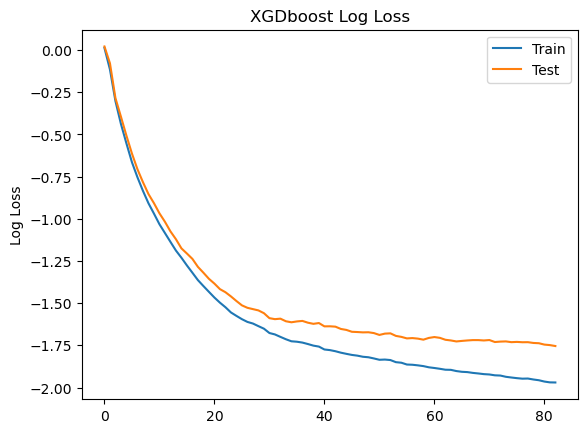

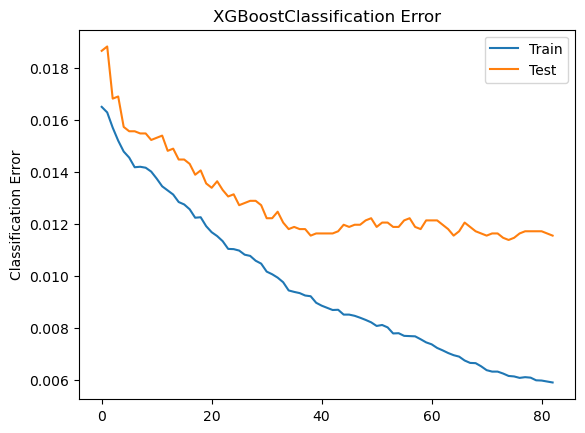

In [29]:
plot_logloss(model)

In [279]:
cross_val_score(model,x_train,y_train,cv=5,scoring='recall')

array([0.69014085, 0.74137931, 0.69905956, 0.73040752, 0.72727273])

In [48]:
x_predict=model.predict(x_test)

In [21]:
recall_score(y_test,x_predict)

0.8218036943136545

In [22]:
f1_score(y_test,x_predict)

0.8920778454885002

In [23]:
model.score(x_test,y_test)

0.9934340353772738

## 结果分析

In [17]:
from sklearn.metrics import roc_curve, auc

In [24]:
# 数据准备
import numpy as np
from sklearn import metrics

# roc_curve的输入为
# y: 样本标签
# scores: 模型对样本属于正例的概率输出
# pos_label: 标记为正例的标签，本例中标记为2的即为正例

fpr, tpr, thresholds = metrics.roc_curve(y_test,x_predict,pos_label=1)

auc = metrics.auc(fpr, tpr)



#### 混淆矩阵

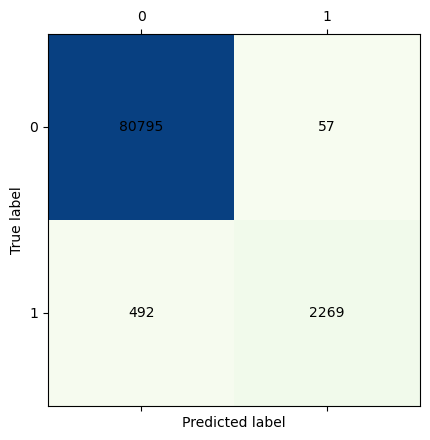

In [33]:

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

y_pred = x_predict 
y_true = y_test


C = confusion_matrix(y_true, y_pred, labels=[0,1])

plt.matshow(C, cmap=plt.cm.GnBu)

for i in range(len(C)):
    for j in range(len(C)):
        plt.annotate(C[j, i], xy=(i, j), horizontalalignment='center', verticalalignment='center')

plt.ylabel('True label')
plt.xlabel('Predicted label')

plt.show()


#### ROC曲线

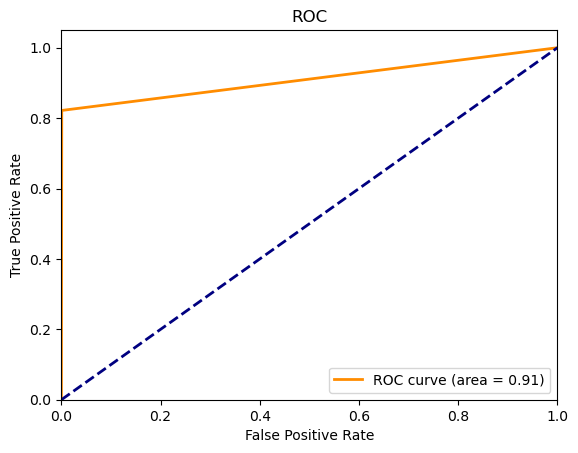

In [28]:
import matplotlib.pyplot as plt
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()


In [42]:
import joblib
joblib.dump(model, './model.pkl')

['./model.pkl']

### 模型评估报告

In [49]:
from sklearn.metrics import classification_report
print(classification_report(y_test, x_predict))#F1-SCORE是测试准确度的量度


              precision    recall  f1-score   support

           0       0.99      1.00      1.00     34627
           1       0.98      0.85      0.91      1207

    accuracy                           0.99     35834
   macro avg       0.99      0.92      0.95     35834
weighted avg       0.99      0.99      0.99     35834

